In [174]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

### Task 2

In [269]:
class Smol:
    
    def __init__(self,C, M, N_iter, dt):
        self.C=C
        self.M=M
        self.N_iter = N_iter
        self.dt=dt   
    
    def get_S(self,n,alpha):
        S = np.sum(n)
        return S
    
    def get_B(self,n,alpha,k,l):
        B = (1+l)*n[k]*self.get_S(n,alpha)
        return B
    
    def get_c(self,n,alpha):
        c = scipy.signal.fftconvolve(n,n)
        return c
            
    def upd_nk(self,n,k,r,l):
        f = 0
        for alpha in range(r):
            f += 1/2*self.get_c(n,alpha)[k-1]-self.get_B(n,alpha,k,l)
        return f*self.dt
    
    def main(self,r,l):
        n = np.zeros(self.M,)
        n[0] = 1 
        nk = np.zeros_like(n)
        for k in range(1,self.M):
            nk[k] = n[k]+self.upd_nk(n,k,r,l)
        nk[0] = np.sum(np.arange(1,self.M+1)*n)-np.sum(np.arange(2,self.M+1)*nk[1:])
        n = np.vstack((n,nk))
        
        
        for t in range(1,self.N_iter):
            for k in range(1,self.M):
                nk[k] = n[-1,k]+self.upd_nk(n[-1,:],k,r,l)
            nk[0] = np.sum(np.arange(1,self.M+1)*n[-1,:])-np.sum(np.arange(2,self.M+1)*nk[1:])
            n = np.vstack((n,nk))
        return n
            
            
        

In [288]:
M = 1000
C = np.ones((M,M))
N_iter = 2000
l = 0.5
dt = 0.01
r = 1
obj = Smol(C, M, N_iter,dt)

In [289]:
res_3 = obj.main(r,l=0.5)
res_1 = obj.main(r,l=0.1)

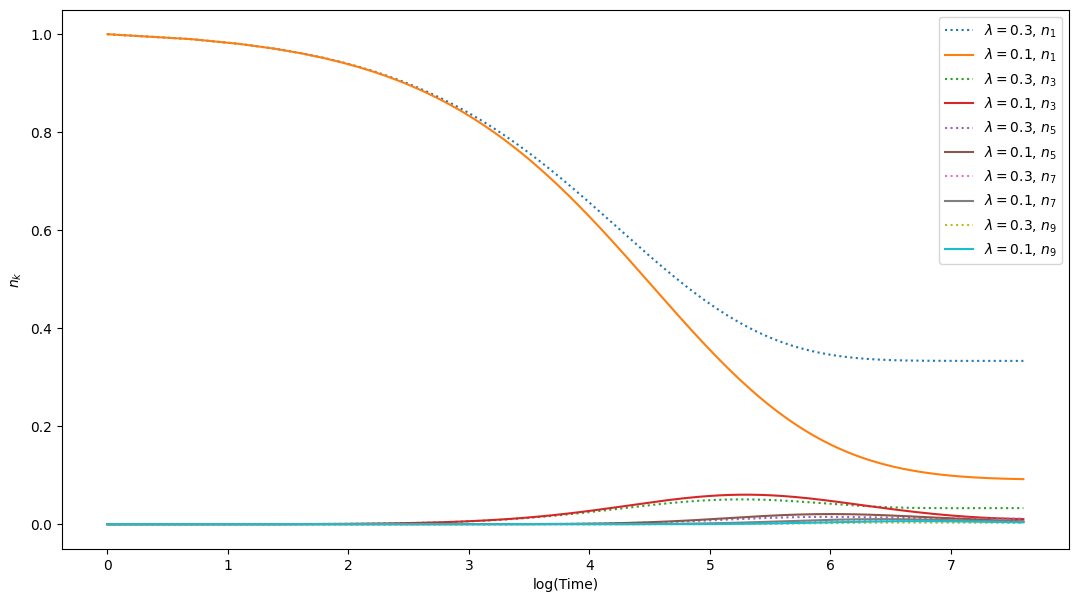

In [438]:
plt.figure(figsize=(13,7))
for i in range(0,5):
    plt.plot(np.log(range(1,N_iter+2)),res_3[:,i*2],label=f'$\lambda = 0.3$, $n_{i*2+1}$', ls='dotted')
    plt.plot(np.log(range(1,N_iter+2)),res_1[:,i*2],label=f'$\lambda = 0.1$, $n_{i*2+1}$', ls='-')
plt.xlabel('log(Time)')
plt.ylabel('$n_k$')
plt.legend()

### Task 3

In [418]:
class Gillespie:
    def __init__(self,N):
        self.N = N
        
    def get_total_rate(self, agg, frag):
        return np.sum(agg)+np.sum(frag)
    
    def get_timestep(self,agg,frag):
        u = np.random.random_sample()
        dt = -np.log(1-u)/self.get_total_rate(agg,frag)
        return dt
    
    def main(self, N_iter, lamb):
        
        numbers = np.zeros((1,self.N))
        numbers[0,0] = self.N
        time = np.array([0])
        agg_rates = np.zeros((self.N,self.N))
        agg_rates[0,:] = numbers[0,:]
        frag_rates = np.zeros((self.N-1,self.N))
        evolution = np.zeros((self.N,1))
        evolution[0] = self.N

        for i in range(N_iter):
            dt = self.get_timestep(agg_rates,frag_rates)
            time = np.append(time,dt+time[-1])
            
            Rs = self.get_total_rate(agg_rates,frag_rates)
            r = np.random.uniform(0,Rs)
            
            rates = np.cumsum(np.hstack((agg_rates.flatten(),frag_rates.flatten())))
            react = np.argmax(-rates+r<0)
            
            x,y = divmod(react,self.N)
            
            if x>=self.N: #fragmentation
                x-=self.N
                numbers[0,0]+=x+y+3
                numbers[0,x+1]-=1
                numbers[0,y] -=1
                
            elif x+y+1<self.N: #aggregation
                numbers[0,x]-=1
                numbers[0,y]-=1
                numbers[0,x+y+1] +=1
                
            else:
                pass
            
            for i in range(self.N):
                agg_rates[i,:] = numbers[0,i]*numbers[0,:]
            for i in range(0,self.N-1):
                frag_rates[i,:] = lamb*numbers[0,i+1]*numbers[0,:]
        
            evolution = np.hstack((evolution,numbers.T))
        return evolution, time
            
            

In [419]:
new = Gillespie(1000)

In [443]:
ev1,t1 = new.main(1000,0.3)
ev2,t2 = new.main(1000,0.1)

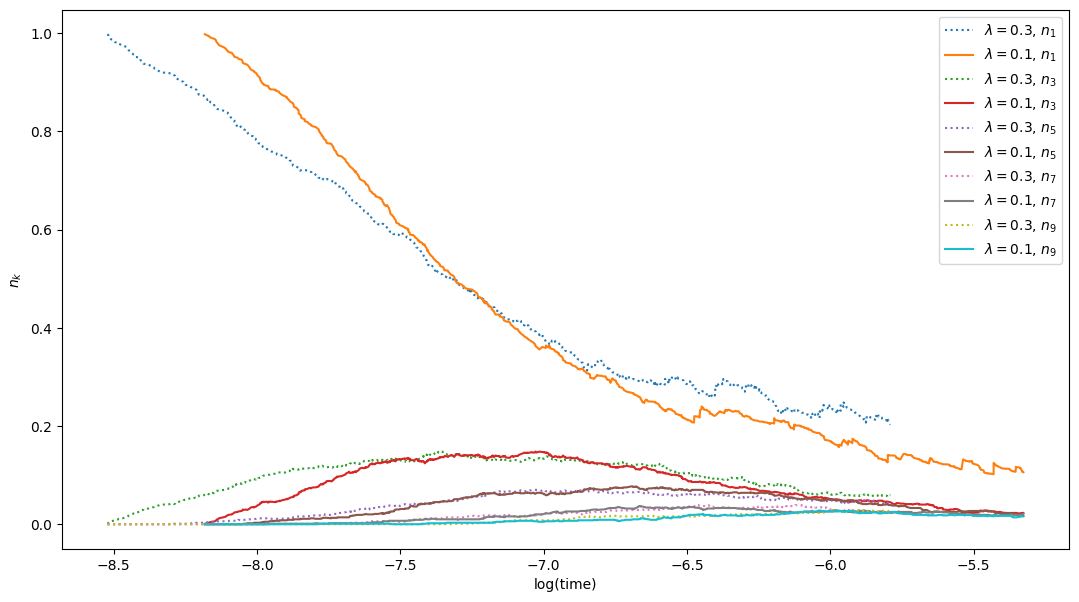

In [446]:
plt.figure(figsize=(13,7))
for i in range(5):
    plt.plot(np.log(t1[1:]),ev1[i,1:]/1000,label=f'$\lambda = 0.3$, $n_{i*2+1}$', ls='dotted')
    plt.plot(np.log(t2[1:]),ev2[i,1:]/1000,label=f'$\lambda = 0.1$, $n_{i*2+1}$', ls='-')
plt.xlabel('log(time)')
plt.ylabel('$n_k$')
plt.legend()